In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [159]:
# load in pre-cleaned deaths data for Texas and comparison states
deaths = pd.read_csv("../20_intermediate_files/deaths_tx.csv")


In [160]:
# two separate dfs - one for texas and one for comp states

texas = deaths[deaths["StateName"] == "Texas"]
comp = deaths[deaths["StateName"] != "Texas"]

### Helper functions 

In [161]:
# function to select only overdose records
# double check this

def select_overdose(record):
    """Simple function to select only overdose records"""

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

# copy to fix the dreaded "A value is trying to be set on a copy of a slice" error
tx_deaths = texas.copy()
comp_deaths = comp.copy()

# apply new function to our df
tx_deaths["overdose"] = tx_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))
comp_deaths["overdose"] = comp_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))

assert len(tx_deaths[tx_deaths["overdose"] == "error"]) == 0
assert len(comp_deaths[comp_deaths["overdose"] == "error"]) == 0

# filter accordingly based on new column
tx_deaths = tx_deaths[tx_deaths["overdose"] != 0]
comp_deaths = comp_deaths[comp_deaths["overdose"] != 0]

In [162]:
# calculate overdoses per 100_000 residents

tx_deaths["overdose_per_100k"] = tx_deaths["Deaths"] / tx_deaths["Population"] * 100_000
comp_deaths["overdose_per_100k"] = comp_deaths["Deaths"] / comp_deaths["Population"] * 100_000

In [163]:
tx_result = tx_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
comp_result = comp_deaths.groupby(["Year", "StateName", "CountyName"])["overdose_per_100k"].sum().reset_index()

# keep validating num counties


# recent change - added county to both results above, removed state from comp_result

In [164]:
# Summary stats - tx and comp states

In [165]:
tx_res = pd.DataFrame(tx_result.describe()["overdose_per_100k"]).rename(columns={"overdose_per_100k": "Overdoses per 100k Residents - Texas"})
comp_res = pd.DataFrame(comp_result.describe()["overdose_per_100k"]).rename(columns={"overdose_per_100k": "Overdoses per 100k Residents - Comp States"})

In [166]:
stats = pd.concat([tx_res, comp_res], axis=1)
stats

,Overdoses per 100k Residents - Texas,Overdoses per 100k Residents - Comp States
count,226.000000,301.000000
mean,10.471761,11.017577
std,6.469153,4.808954
min,1.438121,3.163785
25%,6.541813,7.680168
50%,9.107748,10.058255
75%,11.957830,13.130388
max,42.744176,39.497591


In [167]:
# idea for counties -> histogram of population, drop the outliers?

#plt.hist(tx_deaths["Population"], bins=20)

In [168]:
tx_std = tx_result.groupby("Year")["overdose_per_100k"].std().reset_index()
comp_std = comp_result.groupby(["Year"])["overdose_per_100k"].std().reset_index()

In [169]:
tx_std.rename(columns={"overdose_per_100k": "stddev"}, inplace=True)
comp_std.rename(columns={"overdose_per_100k": "stddev"}, inplace=True)

In [170]:
tx_result = tx_result.groupby("Year")["overdose_per_100k"].mean().reset_index()
comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [171]:
tx_res_checkpoint = tx_result.copy()
comp_res_checkpoint = comp_result.copy()

tx_result = tx_result.merge(tx_std, on="Year", how="outer")
comp_result = comp_result.merge(comp_std, on="Year", how="outer")


# assert length is the same
assert (len(tx_result) == len(tx_res_checkpoint)) & (len(comp_result) == len(comp_res_checkpoint))

In [172]:
comp_result

,Year,overdose_per_100k,stddev
0,2004.0,8.329368,3.196467
1,2005.0,8.955484,3.272332
2,2006.0,10.954411,4.264703
3,2007.0,11.855421,5.901127
4,2008.0,11.298480,4.178085
5,2009.0,12.037253,4.425370
6,2010.0,12.361303,5.805978


In [173]:
#tx_result = tx_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
#comp_result = comp_deaths.groupby(["Year", "County"])["overdose_per_100k"].sum().reset_index()
#
#tx_result = tx_result.groupby("Year")["overdose_per_100k"].mean().reset_index()
#comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

In [174]:
# collapse state column with a mean aggregation
# gives us the average overdoses of our comparison states over the years
#comp_result = comp_result.groupby(["Year"])["overdose_per_100k"].mean().reset_index()

## Pre-post plot - overdoses per 100k through the years

In [219]:
# split into before 2007 and after 2007

tx_b4 = tx_result[tx_result["Year"] < 2007]
tx_after = tx_result[tx_result["Year"] >= 2007]


tx_after = tx_after[tx_after["Year"] != 2007] # may need to handle this differently

In [176]:
from sklearn.linear_model import LinearRegression 

regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(tx_b4["Year"]).reshape(-1, 1)
y_b4 = np.array(tx_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(tx_after["Year"]).reshape(-1, 1)
y_after = np.array(tx_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_after)



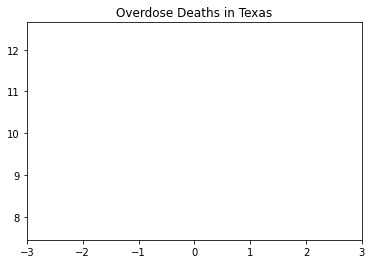

In [177]:
plt.xlim(-3, 3)
#plt.ylim(0, 500)

plt.title("Overdose Deaths in Texas")

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')

# plot avg value in each year


In [178]:
# diff in diff

In [179]:
comp_b4 = comp_result[comp_result["Year"] < 2007]
comp_after = comp_result[comp_result["Year"] >= 2007]

comp_after = comp_after[comp_after["Year"] != 2007] # may need to handle this differently


In [180]:
regressor_b4 = LinearRegression() 
regressor_after = LinearRegression()


X_b4 = np.array(comp_b4["Year"]).reshape(-1, 1)
y_b4 = np.array(comp_b4["overdose_per_100k"]).reshape(-1, 1)

X_after = np.array(comp_after["Year"]).reshape(-1, 1)
y_after = np.array(comp_after["overdose_per_100k"]).reshape(-1, 1)


regressor_b4.fit(X_b4,y_b4) 
regressor_after.fit(X_after,y_after) 


y_pred_b4 = regressor_b4.predict(X_b4)
y_pred_after = regressor_after.predict(X_after)



In [181]:
y_pred_b4

array([[ 8.10056605],
       [ 9.4130878 ],
       [10.72560955]])

In [182]:
y_pred_after

array([[11.3676003 ],
       [11.89901202],
       [12.43042374]])

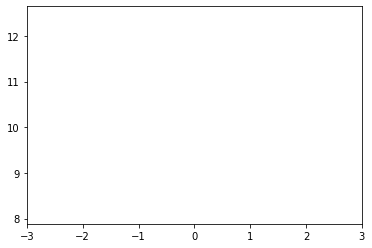

In [183]:
plt.xlim(-3, 3)
#plt.ylim(0, 500)

plt.plot(X_b4, y_pred_b4,color='k')
plt.plot(X_after, y_pred_after,color='k')


In [184]:
# new method after working more with reshaping exercises
# using statsmodels now, wrapping stuff in functions
# thinking it could be easier to break it down by task

## Helper functions

1) vertical_line()
    - takes in a year and plots a vertical line at that year
2) get_charts()
    - takes in two dataframes (one for before policy, one for after)
    - returns chart for each
    - not much utility by itself - used as a parameter for our get_fit() function

In [185]:
x = "Year"
y = "overdose_per_100k"

In [186]:
def vertical_line(year):
    """Function to plot a vertical line at year of policy implementation"""
    line = alt.Chart(pd.DataFrame({
    'Date': [year],
    'color': ["black"]
    })).mark_rule().encode(
    x='Date:Q', # use q for "quantitative" - as per altair docs
    color=alt.Color('color:N', scale=None)
    )

    return line

In [187]:
# test function
line = vertical_line(2007)

In [188]:
def get_charts(b4, after, title_b4, title_after):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("Year", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4)
        
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("Year", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_after)
    )

    return base_before, base_after

In [189]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = tx_b4, after = tx_after, title_b4 = "deaths before policy", title_after="deaths after policy")
base_before + base_after

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.LayerChart(...)

In [190]:
# starting here in final report
# no longer calculating base chart above - just adding in regression line at same time

In [191]:
def get_preds(df, X, y):

    # init new empty df for our predictions
    predictions = pd.DataFrame()

    # fit our model and predict values
    model = smf.ols(f"{y} ~ {X}", data=df).fit()
    model_predict = model.get_prediction(df[X])

    # save predictions back to df, calculate confidence intervals
    predictions["overdose_per_100k"] = model.predict(df[X])
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=0.05)

    # save original year columns to new predictions df
    predictions["Year"] = df["Year"]
    return predictions

In [192]:
tx_b4_preds = get_preds(tx_b4, x, y)
tx_after_preds = get_preds(tx_after, x, y)

In [193]:
def get_charts(b4, after, title_b4, title_after, color):
    """
    Function to plot the pre and post charts.
    Will not use in final plot - used as a baseline for our fit charts later.

    """

    base_before = (
        alt.Chart(b4)
        .mark_point()
        .encode(
            y=alt.Y("overdose_per_100k", scale=alt.Scale(zero=False)),
            x=alt.X("Year", scale=alt.Scale(zero=False)),
        )
        .properties(title=title_b4)
        .transform_regression("Year", "overdose_per_100k")
        .mark_line()
        .encode(color=alt.value(color))
        #.mark_errorband(color="red", opacity=0.5)
        #.encode(x=x, y=alt.Y("ci_low"), y2="ci_high")
    )

    base_after = (
        alt.Chart(after)
        .mark_point()
        .encode(
            y=alt.Y(
                "overdose_per_100k",
                scale=alt.Scale(zero=False),
                title="Overdoses per 100k",
            ),
            x=alt.X(
                "Year",
                scale=alt.Scale(zero=False),
                title="Year (relative to policy)",
            ),
        )
        .properties(title=title_after)
        .transform_regression("Year", "overdose_per_100k")
        #.mark_errorband(color="red", opacity=0.5)
        #.encode(x=x, y=alt.Y("ci_low"), y2="ci_high")
        .mark_line()
        .encode(color=alt.value(color))
    )

    return base_before, base_after

In [194]:
# get ci bands
def get_ci_chart(preds_df, X, y, color):
    ci_chart = (
        alt.Chart(preds_df)
        .mark_errorband()
        .encode(
            x=X,
            y=alt.Y("ci_low", title=y),
            y2="ci_high",
            color=alt.value(color)
        )
    )
    return ci_chart


    
#tx_b4_preds = get_preds(tx_b4, x, y)
#tx_after_preds = get_preds(tx_after, x, y)

tx_b4_bands = get_ci_chart(tx_b4_preds, x, y, "blue")
tx_after_bands = get_ci_chart(tx_after_preds, x, y, "blue")


In [214]:
def get_reg_fit(data, yvar, xvar, alpha=0.05):
    import statsmodels.formula.api as smf

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    reg = alt.Chart(predictions).mark_line().encode(x=xvar, y=yvar)
    ci = (
        alt.Chart(predictions)
        .mark_errorband()
        .encode(
            x=xvar,
            y=alt.Y("ci_low", title=yvar),
            y2="ci_high",
        )
    )
    chart = ci + reg
    return predictions, chart

In [225]:
fit_tx_b4, reg_chart_tx_b4 = get_reg_fit(
    tx_b4, yvar="overdose_per_100k", xvar="Year", alpha=0.05
)
fit_tx_b4


,Year,overdose_per_100k,ci_low,ci_high
0,2004.00,7.686845,-4.135064,19.508754
1,2004.02,7.734154,-3.946467,19.414774
2,2004.04,7.781463,-3.759046,19.321972
3,2004.06,7.828772,-3.572845,19.230389
4,2004.08,7.876081,-3.387909,19.140072
...,...,...,...,...
96,2005.92,12.228525,0.964535,23.492516
97,2005.94,12.275834,0.874217,23.677451
98,2005.96,12.323144,0.782635,23.863652
99,2005.98,12.370453,0.689832,24.051073


In [226]:
fit_tx_after, reg_chart_tx_after = get_reg_fit(
    tx_after, yvar="overdose_per_100k", xvar="Year", alpha=0.05
)
fit_tx_after


,Year,overdose_per_100k,ci_low,ci_high
0,2008.00,10.675487,0.439457,20.911517
1,2008.02,10.678912,0.565217,20.792607
2,2008.04,10.682337,0.689959,20.674716
3,2008.06,10.685763,0.813644,20.557881
4,2008.08,10.689188,0.936233,20.442142
...,...,...,...,...
96,2009.92,11.004299,1.251344,20.757253
97,2009.94,11.007724,1.135605,20.879843
98,2009.96,11.011149,1.018770,21.003527
99,2009.98,11.014574,0.900879,21.128269


In [227]:
reg_chart_tx_b4 + reg_chart_tx_after

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.LayerChart(...)

In [195]:
# test the function
# may remove title parameters later - not really necessary as we aren't plotting this part in our final analysis
# however, if we can't add a title to our fit/regression line charts, we may need to add them here
base_before, base_after = get_charts(b4 = tx_b4_preds, after = tx_after_preds, title_b4 = "Texas - Overdose Deaths Before and After Policy", title_after="Deaths After Policy Implementation", color="blue")
base_before + base_after + line + tx_b4_bands + tx_after_bands

c:\Users\abzdel\AppData\Local\Programs\Python\Python39\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.LayerChart(...)

In [196]:
# same for comparison states (diff in diff)

In [197]:
comp_b4_preds

,overdose_per_100k,ci_low,ci_high,Year
0,8.100566,1.599863,14.601270,2004.0
1,9.413088,5.301682,13.524494,2005.0
2,10.725610,4.224906,17.226313,2006.0


In [198]:
comp_b4_preds = get_preds(comp_b4, x, y)
comp_after_preds = get_preds(comp_after, x, y)

In [199]:
comp_b4_bands = get_ci_chart(comp_b4_preds, x, y, "green")
comp_after_bands = get_ci_chart(comp_after_preds, x, y, "green")

In [201]:
comp_before, comp_after = get_charts(b4 = comp_b4_preds, after = comp_after_preds, title_b4 = "deaths before policy", title_after="deaths after policy", color="green")
base_before + base_after + comp_before + comp_after + line + tx_b4_bands + tx_after_bands + comp_b4_bands + comp_after_bands

alt.LayerChart(...)